In [7]:
import numpy as np

In [54]:
obs = ('normal', 'cold', 'dizzy')

states = ('Healthy', 'Fever')
 
start_p = {'Healthy': 0.6, 'Fever': 0.4}
 
trans_p = {
   'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6}
   }
 
emit_p = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6}
   }


def viterbi(obs, states, start_p, trans_p, emit_p):
    T1 = [{}]
    T2 = {}
    
    for y in states:
        T1[0][y] = start_p[y] * emit_p[y][obs[0]]
        T2[y] = [y]
 
    # Run Viterbi for t > 0
    for t in range(1, len(obs)):
        T1.append({})
        newT2 = {}
 
        for y in states:
            (prob, state) = max((T1[t-1][y0] * trans_p[y0][y] * emit_p[y][obs[t]], y0) for y0 in states)
            T1[t][y] = prob
            newT2[y] = T2[state] + [y]
 
        # Don't need to remember the old T2s
        T2 = newT2
    n = 0           # if only one element is observed max is sought in the initialization values
    if len(obs) != 1:
        n = t
    # print_dptable(V)
    (prob, state) = max((T1[n][y], y) for y in states)
    return (prob, T2[state])
 
# Don't study this, it just prints a table of the steps.
def print_dptable(T1):
    s = "    " + " ".join(("%7d" % i) for i in range(len(T1))) + "\n"
    for y in T1[0]:
        s += "%.5s: " % y
        s += " ".join("%.7s" % ("%f" % v[y]) for v in T1)
        s += "\n"
    print(s)

In [55]:
print(viterbi(obs, states, start_p, trans_p, emit_p))

(0.01512, ['Healthy', 'Healthy', 'Fever'])


Mô hình **BFR** bao gồm ba tập hợp:

- Tập hợp loại bỏ (The discard set): chứa các cụm chính
- Tập hợp nén (The compressed set): chứa các điểm xa khỏi các cụm trong tập loại bỏ nhưng gần nhau. Những điểm này được tổng hợp lại thành các cụm.
- Tập hợp giữ lại (The retained set): chứa các điểm xa khỏi các cụm trong cả tập loại bỏ và tập nén và cũng xa khỏi các điểm khác trong tập giữ lại.

Các bước:

Bước 1: Bước ban đầu của thuật toán là chọn k điểm và để chúng là các cụm chính trong tập loại bỏ.

Bước 2: Sau khi chọn điểm ban đầu, đến lượt của các điểm còn lại.

Bước 3: Đối với mỗi điểm được thêm vào một cụm, tổng và tổng bình phương của cụm được cập nhật. Sau đó, điểm đó được loại bỏ.

Bước 4: Đối với mỗi điểm được thêm vào một cụm, tổng và tổng bình phương của cụm được cập nhật.

In [61]:
class Cluster:
    def __init__(self, centroid):
        self.centroid = centroid
        self.points = []

    def add_point(self, point):
        self.points.append(point)

    def get_points(self):
        return self.points

    def clear_points(self):
        self.points = []

    def update_centroid(self):
        if self.points:
            self.centroid = sum(self.points) / len(self.points)


class BFR:
    def __init__(self, threshold, k):
        self.threshold = threshold
        self.k = k
        self.clusters = []
        
    def fit(self, data):
        # Initiate a cluster for initial data
        self.clusters.append(Cluster(data))
        
        for point in data:
            # Find the closest cluster
            min_dist = float('inf')
            closest_cluster = None
            for cluster in self.clusters:
                dist = cluster.distance_to_center(point)
                if dist < min_dist:
                    min_dist = dist
                    closest_cluster = cluster
            
            # Add point to the closest cluster
            closest_cluster.add_point(point)
            
            # If the closest cluster exceeds threshold, split or merge
            if len(closest_cluster.points) > self.threshold:
                if len(self.clusters) < self.k:
                    closest_cluster.split()
                else:
                    self.merge_clusters()
                    
    def merge_clusters(self):
        # Find the two closest clusters
        min_dist = float('inf')
        closest_pair = None
        for i in range(len(self.clusters)):
            for j in range(i+1, len(self.clusters)):
                dist = self.clusters[i].distance_to_center(self.clusters[j].center)
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (i, j)
        
        # Merge the two closest clusters
        cluster1, cluster2 = self.clusters[closest_pair[0]], self.clusters[closest_pair[1]]
        merged_cluster = Cluster(cluster1.points + cluster2.points)
        self.clusters.remove(cluster1)
        self.clusters.remove(cluster2)
        self.clusters.append(merged_cluster)


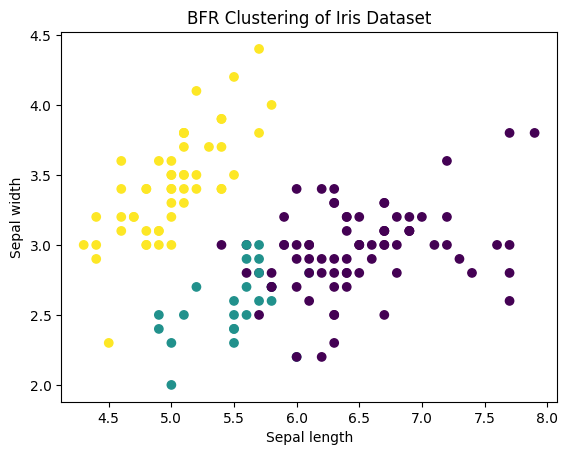

In [62]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import Birch

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Instantiate the BFR clustering algorithm
bfr = Birch(branching_factor=50, n_clusters=3, threshold=0.5)

# Fit the model to the data
bfr.fit(X)

# Get cluster labels
labels = bfr.labels_

# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('BFR Clustering of Iris Dataset')
plt.show()


Thuật toán CURE - Clustering Using REpresentative (Phân cụm bằng Đại diện)

Thuật toán này hoạt động trong không gian Euclidean, nhưng các cụm có thể có bất kỳ hình dạng nào.
Nó xử lý dữ liệu quá lớn để fit vào bộ nhớ chính.
Sử dụng các điểm đại diện trong tập hợp để biểu diễn các cụm.

Bước 1.1: Chọn ngẫu nhiên các điểm mẫu để fit vào bộ nhớ chính.

Bước 1.2: Phân cụm các điểm mẫu theo cấp bậc để tạo ra các cụm ban đầu.

Bước 1.3: Chọn các điểm đại diện:

Đối với mỗi cụm, chọn k điểm đại diện (ví dụ: k=4) sao cho phân tán càng rộng càng tốt.

Di chuyển mỗi điểm đại diện một phần cố định (ví dụ: 20%) về phía trọng tâm của cụm.

Bước 2.1: Quét lại toàn bộ tập dữ liệu và thăm mỗi điểm p trong tập dữ liệu.

Bước 2.2: Đặt nó vào "cụm gần nhất". Gần nhất ở nghĩa là khoảng cách tối thiểu giữa điểm p và tất cả các điểm đại diện.

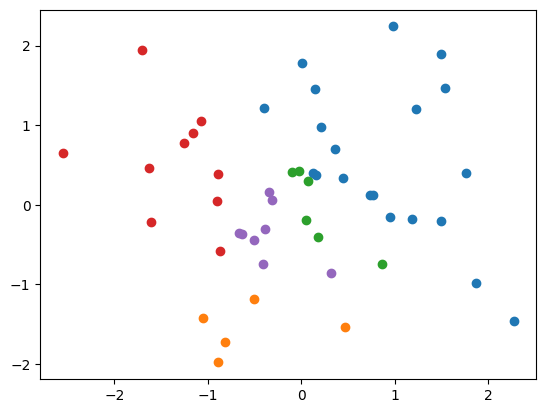

In [71]:
import numpy as np
from scipy.spatial.distance import euclidean

class CURE:
    def __init__(self, k, alpha=0.5):
        self.k = k
        self.alpha = alpha  # Số lượng phần trăm các điểm dữ liệu cần giữ lại sau mỗi lần phân tách
        self.clusters = []

    def fit(self, data):
        self.clusters = self.cure(data, self.k, self.alpha)
        return self.clusters

    def cure(self, data, k, alpha):
        clusters = []

        # Bước 1: Chọn k cụm ban đầu bằng cách sử dụng k-means
        initial_centers = data[np.random.choice(data.shape[0], k, replace=False)]
        initial_clusters = [[] for _ in range(k)]
        for point in data:
            nearest_center = np.argmin([euclidean(point, center) for center in initial_centers])
            initial_clusters[nearest_center].append(point)

        # Bước 2: Giữ lại một phần của các cluster lớn nhất để giảm thiểu ảnh hưởng của noise
        for cluster_points in initial_clusters:
            cluster_size = len(cluster_points)
            num_to_keep = max(int(cluster_size * alpha), 1)
            cluster_points = cluster_points[:num_to_keep]
            clusters.append(cluster_points)

        return clusters

# Dữ liệu mẫu
np.random.seed(0)
data = np.random.randn(100, 2)

# Áp dụng giải thuật CURE
k = 5  # Số lượng cụm cần phân chia
cure = CURE(k)
clusters = cure.fit(data)

# Trực quan hóa kết quả
import matplotlib.pyplot as plt
for cluster in clusters:
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1])
plt.show()


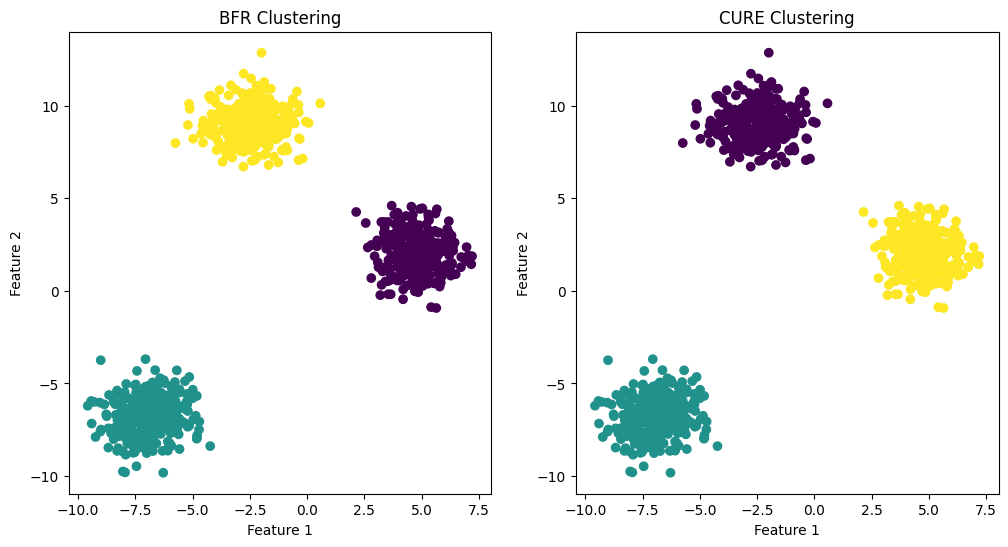

In [78]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np

# Generate sample data
X, _ = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=42)

# BFR Algorithm
class BFR:
    def __init__(self, k_clusters):
        self.k_clusters = k_clusters

    def fit(self, X):
        kmeans = KMeans(n_clusters=self.k_clusters)
        kmeans.fit(X)
        self.clusters = kmeans.cluster_centers_

    def predict(self, X):
        labels = np.argmin(np.linalg.norm(X[:, None] - self.clusters, axis=2), axis=1)
        return labels

# CURE Algorithm
class CURE:
    def __init__(self, k_clusters, fraction):
        self.k_clusters = k_clusters
        self.fraction = fraction

    def fit(self, X):
        kmeans = KMeans(n_clusters=self.k_clusters)
        kmeans.fit(X)
        self.clusters = kmeans.cluster_centers_

        for i in range(self.k_clusters):
            indices = np.where(kmeans.labels_ == i)[0]
            cluster_points = X[indices]

            centroid = np.mean(cluster_points, axis=0)
            self.clusters[i] = centroid

            for j in range(len(cluster_points)):
                move_distance = self.fraction * np.linalg.norm(cluster_points[j] - centroid)
                direction = (centroid - cluster_points[j]) / np.linalg.norm(cluster_points[j] - centroid)
                self.clusters[i] = self.clusters[i] + move_distance * direction

    def predict(self, X):
        labels = np.argmin(np.linalg.norm(X[:, None] - self.clusters, axis=2), axis=1)
        return labels

# Example usage
bfr = BFR(k_clusters=3)
bfr.fit(X)
bfr_labels = bfr.predict(X)

cure = CURE(k_clusters=3, fraction=0.2)
cure.fit(X)
cure_labels = cure.predict(X)

# Visualize the clusters
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=bfr_labels, cmap='viridis')
plt.title('BFR Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=cure_labels, cmap='viridis')
plt.title('CURE Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()
